In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

In [ ]:
#Mount my Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/APM_B10/train.csv"
df = pd.read_csv(path)
df.head()

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
3,08672eddcb2b7c93,http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...,13287
4,fc49cb32ef7f1e89,http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...,4018


In [ ]:
filtered = df.groupby('landmark_id')['url'].filter(lambda x: len(x) >= 100)
df_filter = df[df['url'].isin(filtered)]
df_filter = df_filter.replace(to_replace='None', value=np.nan).dropna()
df_filter

,id,url,landmark_id
0,97c0a12e07ae8dd5,http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...,6347
1,650c989dd3493748,https://lh5.googleusercontent.com/-PUnMrX7oOyA...,12519
2,05e63ca9b2cde1f4,http://mw2.google.com/mw-panoramio/photos/medi...,264
5,056708de792326b9,https://lh3.googleusercontent.com/-nbz_XT1dGz4...,5046
6,6ae1e206c579f649,https://lh6.googleusercontent.com/-onL5-pK9nZI...,5554
...,...,...,...
1225024,4bb5a501e5b26a6a,https://lh6.googleusercontent.com/-mRrQU3t5cYw...,9737
1225025,2cd8a404796cfe0e,https://lh6.googleusercontent.com/-0UB5gFx6w7M...,7758
1225026,8733b8b469fb8c1b,http://lh3.ggpht.com/-TDQWNVvJQDI/SI3HZSA4D3I/...,13170
1225027,14dd9e8790397c83,https://lh4.googleusercontent.com/-anV4Xpo0UuM...,5669


In [ ]:
#Select only id from 1000-2000 to save time
landmark_list = [str(x) for x in list(range(1000,2000))]
data_sample = df_filter[df_filter['landmark_id'].isin(landmark_list)]
data_sample.landmark_id.value_counts()

1553    7653
1878    2285
1847    1642
1946    1533
1602    1466
        ... 
1771     103
1458     102
1135     102
1930     102
1879     100
Name: landmark_id, Length: 131, dtype: int64

In [ ]:
#Ref: https://www.kaggle.com/lyakaap/fast-resized-image-download-python-3
import re
TARGET_SIZE = 96 #imports images of resolution 96x96

'''change URLs to resize images to target size'''
def overwrite_urls(df):
    def reso_overwrite(url_tail, reso=TARGET_SIZE):
        pattern = 's[0-9]+'
        search_result = re.match(pattern, url_tail)
        if search_result is None:
            return url_tail
        else:
            return 's{}'.format(reso)
    
    def join_url(parsed_url, s_reso):
        parsed_url[-2] = s_reso
        return '/'.join(parsed_url)
    
    df = df[df.url.apply(lambda x: len(x.split('/'))>1)]
    parsed_url = df.url.apply(lambda x: x.split('/'))
    train_url_tail = parsed_url.apply(lambda x: x[-2])
    resos = train_url_tail.apply(lambda x: reso_overwrite(x, reso=TARGET_SIZE))

    overwritten_df = pd.concat([parsed_url, resos], axis=1)
    overwritten_df.columns = ['url', 's_reso']
    df['url'] = overwritten_df.apply(lambda x: join_url(x['url'], x['s_reso']), axis=1)
    return df

data_sample_resize = overwrite_urls(data_sample)
print ('1. URLs overwritten')

1. URLs overwritten


In [ ]:
train_dir = r'/content/drive/My Drive/APM_B10/N_train_images_model/'
validation_dir = r'/content/drive/My Drive/APM_B10/M_validation_images_model/'
test_dir = r'/content/drive/My Drive/APM_B10/N_test_images_from_train/'

In [ ]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 240
IMG_SIZE = (96,96)

train_dataset = image_dataset_from_directory(train_dir,
                                             labels='inferred',
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                             labels='inferred',
                                             label_mode='categorical',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            labels='inferred',
                                            label_mode='categorical',
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 36475 files belonging to 131 classes.
Found 9591 files belonging to 131 classes.
Found 439 files belonging to 131 classes.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./95.)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/95.)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 240, target_size = (96, 96))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,  batch_size = 240, target_size = (96, 96))

Found 36475 images belonging to 131 classes.
Found 9591 images belonging to 131 classes.


In [ ]:
len(train_generator)

152

# Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50
base_model3 = ResNet50(input_shape=(96, 96,3), include_top=False, weights="imagenet")

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model3.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

base_model3 = Sequential()
base_model3.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model3.add(Dense(131, activation='softmax',name="predictions"))

In [ ]:
def top_1_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

base_model3.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01), loss = 'categorical_crossentropy', metrics = [top_1_accuracy])

In [ ]:
resnet_history = base_model3.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 10)

Epoch 1/10
14/20 [====================>.........] - ETA: 5:24 - loss: 6.8203 - top_1_accuracy: 0.1167

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


20/20 [==============================] - 3421s 171s/step - loss: 6.2539 - top_1_accuracy: 0.1565 - val_loss: 83.0393 - val_top_1_accuracy: 0.0177
Epoch 2/10
20/20 [==============================] - 945s 47s/step - loss: 3.6891 - top_1_accuracy: 0.3415 - val_loss: 83.1591 - val_top_1_accuracy: 0.0078
Epoch 3/10
20/20 [==============================] - 822s 41s/step - loss: 2.7780 - top_1_accuracy: 0.4688 - val_loss: 22.7365 - val_top_1_accuracy: 0.0155
Epoch 4/10
20/20 [==============================] - 716s 36s/step - loss: 2.3234 - top_1_accuracy: 0.5450 - val_loss: 18.7182 - val_top_1_accuracy: 0.0083
Epoch 5/10
20/20 [==============================] - 600s 30s/step - loss: 1.7305 - top_1_accuracy: 0.6359 - val_loss: 7.7572 - val_top_1_accuracy: 0.0047
Epoch 6/10
20/20 [==============================] - 522s 26s/step - loss: 1.4222 - top_1_accuracy: 0.6860 - val_loss: 6.6231 - val_top_1_accuracy: 0.0047
Epoch 7/10
20/20 [==============================] - 472s 24s/step - loss: 1.2113 

In [ ]:
#predictions
loss, accuracy = base_model3.evaluate(test_dataset)

2/2 [==============================] - 1s 441ms/step - loss: 13.6288 - top_1_accuracy: 0.0228


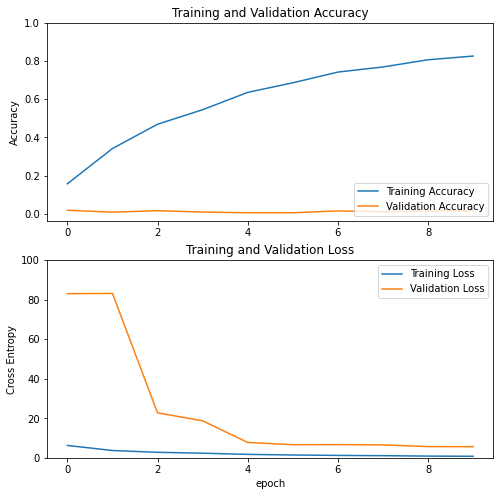

In [ ]:
#loss curve
acc = resnet_history.history['top_1_accuracy']
val_acc = resnet_history.history['val_top_1_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,100.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
while True:
  pass

KeyboardInterrupt: ignored